# Introduction
New York City is a melting pot for cultures and cuisines. You should be able to find any s of cuisines you can imagine in NYC.
One of the most delicious and diverse cuisines is Persian (Iranian) food. Persian cuisine’s diversity comes from the variety of cultures in Iran. There are endless varieties of dishes and breads; made with ingredients that are native to Iran, such as saffron, pistachios and walnuts.
When you Google ‘Persian Restaurants in New York’ a good number of them show up. When you check the Category of the restaurant, they are mostly listed as “Mediterranean Cuisine”! Persian and Mediterranean have a lot of common ground but there are many authentic Iranian dishes that are usually not available in most Mediterranean restaurants. However, I believe since the Mediterranean cuisines are more known in America, Persian restaurant businesses label themselves as such so they appear more in searches! Thus, in order to have a wider search in this project I’m going to request and analyze data related to the Mediterranean restaurants.


## Business Problem
This project can be helpful for all the investors looking for great business opportunities in the restaurant industry. Opening a Persian restaurant in general is a great business idea since it has something to offer for every taste! However, in this project I am about to dig deep into New York City’s neighborhoods to find the best location to open a new Persian restaurant. I am also going to find out where we can find the best Mediterranean food in NYC today! Understanding how current businesses are doing in different neighborhoods can lead us to a better decision on where to open a new one.

## Data Required and Sources
In order to tackle the problem statement, we would need a very thorough data on New York City. In addition to NYC Boroughs and Neighborhoods, we would need the latitude and longitude of each area to be able to use visualization maps and achieve a better analysis. We would also need detail of each venue and Mediterranean restaurant, such as the rankings, number of likes and tips given by customers.

Many online sources provide data on different locations around the world. In this project, I am going to use data from http://cocl.us/new_york_dataset to get the data on New York City’s boroughs and neighborhoods. The geographical coordination (latitude and longitude) of each neighborhood can then be accesses through Python package called Geocoder. In addition, Folium can be used to create the visualization maps.
Foursquare has a large database including different venues information. Here, we are interested in restaurants’ data. Getting access to the Foursquare API we can access information on restaurants in New York City’s different neighborhoods. We can also get access to restaurants rankings, and other details such as number of likes and tips given on Foursquare! 
Putting all the information together we can have a good idea of the number of Mediterranean restaurants in each neighborhood and find the best ranking Mediterranean restaurants in town.  Having all the information discussed in previous sections help the investors decide where is the best location to open a new Mediterranean restaurant. Moreover, by looking at the statistical data on current businesses they can project how successful their business will be in the future!

In [4]:
#importing libraries and packages that are going to be used.
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests 

from bs4 import BeautifulSoup
import os

#installing map rendering library
!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim #converts an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Importing is all DONE!')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Importing is all DONE!


To be able to use Foursquare I need to provide my variables:

In [5]:
#I need to define Foursquare Credentials ( Client ID and the Client Secret ID)
#and the Foursquare API version
CLIENT_ID = 'YX50D425ZLUUX5PTQMTKGCTQYWBYN3FYHWUPZ5HNDJBQBFMO' 
CLIENT_SECRET = 'G5LUPYDPQ12X1DSCYEMTCUNA0UFWXJX1VBLG2CRPMRVHITO2' 
VERSION = '20180605'

In [6]:
#defining functions to get latitude and longitue of locations
def geo_location(address):
    geolocator = Nominatim(user_agent="foursquare_persian_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

#setting variables, and providing url to fetch data from foursquare api
def get_venues(lat,lng):
    radius=400
    LIMIT=100
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
#requesting data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#now doing the same thing but to get venue details such as ratings, tips etc.
def get_venue_details(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

print("All functions are defined!")

All functions are defined!


Now that we have imported our libraries and defined our functions and set our requests from Foursquare, it is time to get some data about New York City:

In [7]:
nyc_data=get_new_york_data()
nyc_data.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


Seems that each Borough in NYC is consisted of many Neighborhoods. In order to find out how many different Neighborhoods we have in our data we can use the .shape method:

In [8]:
nyc_data.shape

(306, 4)

Our data includes 306 different Neighborhoods in NYC.

Just to get an idea, I'm going to use a bar plot visualization to see how many Neighborhoods are there in each Borough:

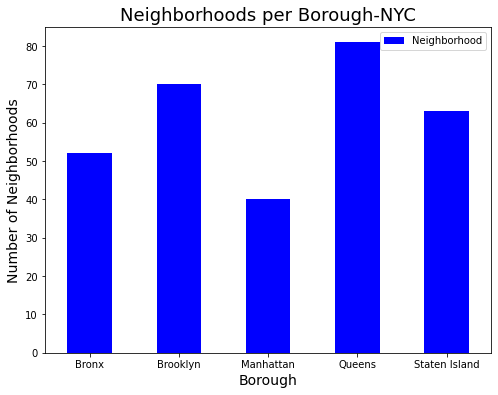

In [9]:
clr = "blue"
nyc_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(8,6), color=clr)
plt.title('Neighborhoods per Borough-NYC', fontsize = 18)
plt.xlabel('Borough', fontsize = 14)
plt.ylabel('Number of Neighborhoods',fontsize = 14)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

Some of NYC's Boroughs such as Queens has around 80 different Neighborhoods!

## Mediterranean Restaurants in Each Neighborhood
Now it's time to look into each Borough and Neighborhood to see how many Persian restaurants are out there!Just a quick google search and it's obvious that most of Persian Restaurants have identified themselves as Mediterranean cuisine. Since not many people know about Persian Cuisine, it might be wise for businesses to include themselves in a bigger and much known category. If they tag their restaurant as let's say "Mediterranean" then they will show up in more searches! 
Thus, I'm going to set the Category as 'Mediterranean Restuarant' to catch all possible Persian restuarants in NYC:

In [10]:
#queens has most neighborhoods
#prepare neighborhood list that contains persian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
persian_rest_nyc=pd.DataFrame(columns=column_names)
count=1
for row in nyc_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    persian_restaurants=venues[venues['Category']=='Mediterranean Restaurant']   
    print('(',count,'/',len(nyc_data),')','Persian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(persian_restaurants)))
    print(row)
    for resturant_detail in persian_restaurants.values.tolist():
        id, name , category=resturant_detail
        persian_rest_nyc = persian_rest_nyc.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Persian Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Persian Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Persian Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Persian Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Persian Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Persian Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Persian Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Persian Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Persian Restaurants in Norwood, Bronx:0
['

Since we have limited amount of calls in Foursquare, I'm going to save this data as .csv for our reference:

In [11]:
#saving the information to a .csv file 
persian_rest_nyc.to_csv('persian_rest_nyc_tocsv1.csv')

In [12]:
#let's have a glance of our data
persian_nyc = pd.read_csv('persian_rest_nyc_tocsv1.csv')
persian_rest_nyc.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Belmont,4d15118a816af04d110741c2,Gurra Cafe
1,Brooklyn,Brighton Beach,4c819efadc018cfae6ddc76c,Beyti Turkish Kebab
2,Brooklyn,Bushwick,59c58cc2bd40097ff68f8466,Zatar
3,Brooklyn,East Williamsburg,51353096e4b0885722745260,Healthy Choice Kitchen
4,Brooklyn,North Side,5f2dd84ac551a43bd01f03d8,Strangeways


In [13]:
persian_rest_nyc.shape

(39, 4)

There are 39 Mediterranean restuarants in NYC. 

Now let's see how many are in each New York City's Borough:

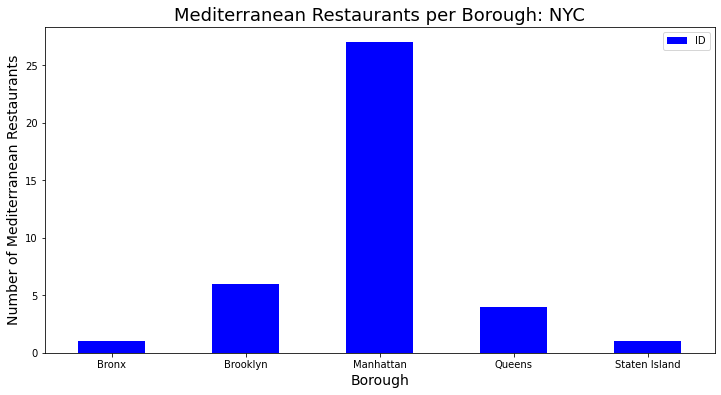

In [14]:
persian_rest_nyc.groupby('Borough')['ID'].count().plot.bar(figsize=(12,6), color=clr)
plt.title('Mediterranean Restaurants per Borough: NYC', fontsize = 18)
plt.xlabel('Borough', fontsize = 14)
plt.ylabel('Number of Mediterranean Restaurants', fontsize=14)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

So as you can see Manhattan has the most number of Mediterranean restuarants! Although Manhattan is relatively a small Borough it has around 25 mediterranean restuarants!

In [15]:
persian_rest_nyc.groupby('Borough')['Neighborhood'].count()

Borough
Bronx             1
Brooklyn          6
Manhattan        27
Queens            4
Staten Island     1
Name: Neighborhood, dtype: int64

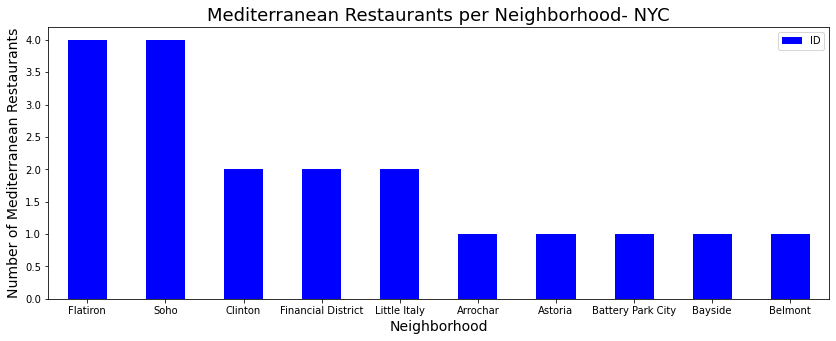

In [16]:
NumofNeigh = 10 #showing 10 neighborhoods on the graphs
persian_rest_nyc.groupby('Neighborhood')['ID'].count().nlargest(NumofNeigh).plot.bar(figsize=(14,5), color=clr)
plt.title('Mediterranean Restaurants per Neighborhood- NYC', fontsize = 18)
plt.xlabel('Neighborhood', fontsize = 14)
plt.ylabel('Number of Mediterranean Restaurants', fontsize=14)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

Flatiron and Soho neighborhoods have the highest number of Mediterranean restuarants.
Let's just pick the top 5 neighborhoods and check out the restuarants:

In [17]:
persian_rest_nyc[persian_rest_nyc['Neighborhood']=='Flatiron']

,Borough,Neighborhood,ID,Name
34,Manhattan,Flatiron,5c5869388b98fd002c5de209,CAVA
35,Manhattan,Flatiron,4ae32479f964a520e09021e3,Barbounia
36,Manhattan,Flatiron,573363c2498eb18e283007f8,Bite
37,Manhattan,Flatiron,4f331c5ce4b05255bdf07d27,The Hummus & Pita Co


In [18]:
persian_rest_nyc[persian_rest_nyc['Neighborhood']=='Soho']

,Borough,Neighborhood,ID,Name
18,Manhattan,Soho,4a05ea5cf964a5209b721fe3,Antique Garage
19,Manhattan,Soho,4f0f47650cd695a0e54cb438,Jack's Wife Freda
20,Manhattan,Soho,5b9ef2d9f8cbd4002c8c7c1e,19 Cleveland
21,Manhattan,Soho,59e0ee84f0ca95526b7fce9f,CAVA


In [23]:
persian_rest_nyc[persian_rest_nyc['Neighborhood']=='Clinton']

,Borough,Neighborhood,ID,Name
10,Manhattan,Clinton,56aff9ef498e60c01f7b2a21,Mémé Mediterranean
11,Manhattan,Clinton,4f05ed7fd3e321b78fda80b0,Turco Mediterranean Grill


In [19]:
persian_rest_nyc[persian_rest_nyc['Neighborhood']=='Financial District']

,Borough,Neighborhood,ID,Name
25,Manhattan,Financial District,5cf62af9cb3fd2002c8e8a4c,CAVA
26,Manhattan,Financial District,5187b7ca498e26e78cc393a9,Roti Modern Mediterranean


In [20]:
persian_rest_nyc[persian_rest_nyc['Neighborhood']=='Little Italy']

,Borough,Neighborhood,ID,Name
16,Manhattan,Little Italy,5b9ef2d9f8cbd4002c8c7c1e,19 Cleveland
17,Manhattan,Little Italy,59e0ee84f0ca95526b7fce9f,CAVA


I can see that there's almost one 'CAVA' in the neighborhoods! out of curiosity I'm going to see out of 39 overall Mediterranean restaurants how many 'CAVA' restaurants are there?!

In [21]:
persian_rest_nyc[persian_rest_nyc['Name']=='CAVA']

,Borough,Neighborhood,ID,Name
12,Manhattan,Midtown,5b9fe1ef93bd63002c3bbb7b,CAVA
17,Manhattan,Little Italy,59e0ee84f0ca95526b7fce9f,CAVA
21,Manhattan,Soho,59e0ee84f0ca95526b7fce9f,CAVA
25,Manhattan,Financial District,5cf62af9cb3fd2002c8e8a4c,CAVA
34,Manhattan,Flatiron,5c5869388b98fd002c5de209,CAVA


So there are 5 'CAVA' restuarants and all are in Manhattan!

Let's look at how many unique Mediterranean restaurants we have:

In [22]:
persian_rest_nyc.Name.unique()

array(['Gurra Cafe', 'Beyti Turkish Kebab', 'Zatar',
       'Healthy Choice Kitchen', 'Strangeways', 'Trufa', 'Flora Bar',
       'Mokum', 'Boulud Sud', 'Mémé Mediterranean',
       'Turco Mediterranean Grill', 'CAVA',
       "Omar's Mediterranean Cuisine", 'Shuka', 'Zyara Restaurant & Cafe',
       '19 Cleveland', 'Antique Garage', "Jack's Wife Freda",
       'Elysian Fields Cafe', 'Atrio New York',
       'Roti Modern Mediterranean', 'Farid Kebab, Steinway', 'Chickpea',
       "Maria's Restaurant", 'Painico Cafe', 'Seaside Turkish Restaurant',
       'Pergola', 'Anassa Taverna', 'Barbounia', 'Bite',
       'The Hummus & Pita Co', 'Celestine'], dtype=object)

There are 32 unique restaurants so some of them are chain restuarants such as 'CAVA'!

Now let's get into more detail and see which one of these restaurants have the highest ranking:

In [23]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
persian_rest_stats_nyc=pd.DataFrame(columns=column_names)
count=1
for row in persian_rest_nyc.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        #I will assign 0 value for these resturants as they may have been 
        #opened recently or information doesn't exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(persian_rest_nyc),')','processed')
    persian_rest_stats_nyc = persian_rest_stats_nyc.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
persian_rest_stats_nyc.tail()

{'meta': {'code': 200, 'requestId': '5fe0f471d5239e00e265e62b'}, 'response': {'venue': {'id': '4d15118a816af04d110741c2', 'name': 'Gurra Cafe', 'contact': {'phone': '7182204254', 'formattedPhone': '(718) 220-4254'}, 'location': {'address': '2325 Arthur Ave', 'lat': 40.85388958454132, 'lng': -73.88896822929382, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85388958454132, 'lng': -73.88896822929382}, {'label': 'entrance', 'lat': 40.853935, 'lng': -73.889109}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2325 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gurra-cafe/4d15118a816af04d110741c2', 'categories': [{'id': '4bf58dd8d48988d1c0941735', 'name': 'Mediterranean Restaurant', 'pluralName': 'Mediterranean Restaurants', 'shortName': 'Mediterranean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mediterranean_', 'suffix': '.png'}, 'primary': True}], 'v

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
34,Manhattan,Flatiron,5c5869388b98fd002c5de209,CAVA,50,8.7,3
35,Manhattan,Flatiron,4ae32479f964a520e09021e3,Barbounia,613,8.6,208
36,Manhattan,Flatiron,573363c2498eb18e283007f8,Bite,193,8.6,56
37,Manhattan,Flatiron,4f331c5ce4b05255bdf07d27,The Hummus & Pita Co,485,8.2,128
38,Brooklyn,Dumbo,59dd280192e7a97276e4d52f,Celestine,123,7.9,26


In [24]:
#saving the data to a .csv file
persian_rest_stats_nyc.to_csv('persian_rest_stats_nyc_csv.csv') 

In [25]:
persian_rest_stats_nyc.shape

(39, 7)

Let's check some information such as data types in our dataframe:

In [26]:
persian_rest_stats_nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       39 non-null     object
 1   Neighborhood  39 non-null     object
 2   ID            39 non-null     object
 3   Name          39 non-null     object
 4   Likes         39 non-null     object
 5   Rating        39 non-null     object
 6   Tips          39 non-null     object
dtypes: object(7)
memory usage: 2.3+ KB


We need to convert the likes, rating and tips data values from string values (objects) to floats, to be able to perform further statical analysis in Python:

In [32]:
persian_rest_stats_nyc['Likes'] = persian_rest_stats_nyc['Likes'].astype('float64')
persian_rest_stats_nyc['Tips'] = persian_rest_stats_nyc['Tips'].astype('float64')
persian_rest_stats_nyc['Rating']=persian_rest_stats_nyc['Rating'].astype('float64')
persian_rest_stats_nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       39 non-null     object 
 1   Neighborhood  39 non-null     object 
 2   ID            39 non-null     object 
 3   Name          39 non-null     object 
 4   Likes         39 non-null     float64
 5   Rating        39 non-null     float64
 6   Tips          39 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.3+ KB


To get more statistical insight, I'm going to use the .describe method to get some overall detail on the Mediterranean restaurants in NYC:

In [29]:
persian_rest_stats_nyc.describe()

,Likes,Tips
count,39.000000,39.000000
mean,167.128205,47.871795
std,296.560740,89.094031
min,0.000000,0.000000
25%,16.000000,3.500000
50%,77.000000,23.000000
75%,157.500000,54.500000
max,1720.000000,513.000000


In [30]:
#restaurant with the most number of Likes
persian_rest_stats_nyc.iloc[persian_rest_stats_nyc['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                        Soho
ID              4f0f47650cd695a0e54cb438
Name                   Jack's Wife Freda
Likes                               1720
Rating                               8.7
Tips                                 513
Name: 19, dtype: object

So based on results, Jack's Wife Freda located in Soho (Manhattan) has the highest number of likes. This restuarant has 1,720 likes! The ranting of this restaurant is 8.7 out of 10.

Now let's find the Mediterranean restuarant with the highest ranking:

In [33]:
#Restaurant with most Ratings
persian_rest_stats_nyc.iloc[persian_rest_stats_nyc['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              59e0ee84f0ca95526b7fce9f
Name                                CAVA
Likes                                109
Rating                               9.3
Tips                                  13
Name: 17, dtype: object

Looks like one of the CAVA restaurants (located in Little Italy in Manhattan) has the highest ranking of 9.3 out of 10.

Now let's see the average Mediterranean restaurant ratings in different neighborhoods, and which neighborhood has the highest and lowest average ratings:

In [43]:
nyc_neighborhood_stats=persian_rest_stats_nyc.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
nyc_neighborhood_stats.columns=['Neighborhood','Avg. Rating']
nyc_neighborhood_stats.sort_values(['Avg. Rating'],ascending=False).head(30)

,Neighborhood,Avg. Rating
29,West Village,9.300
15,Little Italy,9.250
21,Murray Hill,9.000
12,Greenwich Village,9.000
24,Soho,8.950
17,Lower East Side,8.900
18,Midtown,8.800
28,Upper West Side,8.700
27,Upper East Side,8.600
11,Flatiron,8.525


The results are in and it seems that West Village has the highest average rating among the Mediterranean restaurant (average rating of 9.30). On the other hand, Rockaway Park has the lowest averge ranking of 6.2.
Soho that is one of the neighborhoods with highest number of Mediterranean restaurants has an average rating of 8.90.

In [40]:
nyc_borough_stats=persian_rest_stats_nyc.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
nyc_borough_stats.columns=['Borough','Avg. Rating']
nyc_borough_stats.sort_values(['Avg. Rating'],ascending=False).head()

,Borough,Avg. Rating
2,Manhattan,8.529630
1,Brooklyn,7.916667
3,Queens,6.950000
4,Staten Island,6.800000
0,Bronx,0.000000


Looks like Manhattan has the highest average rating among the Mediterranean restuarants!(are we surprised?)

Now let's filter our Neighborhoods with average ratings of 8.5 and higher:

In [38]:
nyc_neighborhood_stats=nyc_neighborhood_stats[nyc_neighborhood_stats['Avg. Rating']>=8.5]
nyc_neighborhood_stats

,Neighborhood,Avg. Rating
11,Flatiron,8.525
12,Greenwich Village,9.000
14,Lincoln Square,8.500
15,Little Italy,9.250
17,Lower East Side,8.900
18,Midtown,8.800
21,Murray Hill,9.000
22,North Side,8.500
24,Soho,8.950
25,South Side,8.500


It's time to merge this data with our nyc_data to get the latitude and lonitude of restaurants for visualization purposes:

In [44]:
nyc_neighborhood_stats=pd.merge(nyc_neighborhood_stats,nyc_data, on='Neighborhood')
nyc_neighborhood_stats=nyc_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Avg. Rating']]
nyc_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Avg. Rating
0,Staten Island,Arrochar,40.596313,-74.067124,6.800
1,Queens,Astoria,40.768509,-73.915654,7.500
2,Manhattan,Battery Park City,40.711932,-74.016869,7.700
3,Queens,Bayside,40.766041,-73.774274,7.500
4,Bronx,Belmont,40.857277,-73.888452,0.000
5,Brooklyn,Brighton Beach,40.576825,-73.965094,8.100
6,Brooklyn,Bushwick,40.698116,-73.925258,8.000
7,Manhattan,Clinton,40.759101,-73.996119,8.450
8,Brooklyn,Dumbo,40.703176,-73.988753,7.900
9,Brooklyn,East Williamsburg,40.708492,-73.938858,6.500


In [46]:
#creating map using Folium and displaying it
nyc_map = folium.Map(location=geo_location('New York'), zoom_start=12)
#creating a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in nyc_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, 
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    
nyc_map

In [50]:
nyc_neighborhood_stats['Label']=nyc_neighborhood_stats['Neighborhood']+', '+nyc_neighborhood_stats['Borough']+'('+nyc_neighborhood_stats['Avg. Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in nyc_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(nyc_map)        
# add ratings to map
nyc_map.add_child(rating)

So now if we click on any of the tags you can see the name of the neighborbood, its borough and also the Mediterranean restaurants's average ratings!

## Results

Based on our data analysis, there re total of 39 Mediterranean restaurants listed in Foursquare API in the city of New York!
With 27 Mediterranean restaurants, Manhattan has the highest number among other boroughs!
Soho and Flatiron neighborhoods have highest number of Mediterranean restaurants (5 each!).
After filtering results, I found out there are 32 unique restuarants, and the remaining 7 are all chain restaurants.

Then I dug into the restaurants details;
By changing some of the data type values from 'object' to 'float64', I was able to perform some statistical analysis.
The restaurant with the highest rating is CAVA- located in Little Italy, Manhattan. This location has a rating of 9.30.
The Jack's Wife Freda located in Soho, Manhattan, has the highest number of 'Likes'! (total of 1,720)

After sorting the neighborhoods based on their Mediterranean restaurants' average ratings, West Village has the highest average rating (9.30). Rockaway has the lowest average rating of 6.20 amongst other neighborhoods. There are some neighborhoods with no Mediterranean restaurant ratings such as Belmont!

The Mediterranean restuarants in Manhattan have the highest average rating!

## Conclusion

In conclusion, I would suggest the investors to open their new Persian restaurant in Manhattan and in Soho neighborhood! Although Soho has 5 other Mediterranean restaurant it seems that they all have a high rate of success! It seems that due to high demand, Manhattan has many restaurants and majority are successful! Based on the name of the restaurants, unfortunately I did not detect any Persian restaurants! Which might be a great news to the invetors since it shows there's a huge opportunity in opening a brand new Persian restaurant in the heart of Soho!
I would also make sure I try out the Jack's Wife Freda next time in town!
Finally, I would suggest a more thorough analysis using multiple location data sources! All the analysis in this report depend on the Foursquare data accuracy and limitations! 